In [1]:
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [3]:
d = 200
model = nn.Sequential(
    # какие-нибудь nn.Linear и нелинейности
    # ...
    nn.Linear(28*28, d),
    nn.ReLU(),
    nn.Linear(d, d),
    nn.ReLU(),

    nn.Linear(d, 10),
    nn.LogSoftmax(dim=1)
)

In [4]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total
accuracy(model, train)

0.10818333333333334

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.NLLLoss()

0.9324166666666667 0.9341
0.9597166666666667 0.9555
0.9700666666666666 0.9635
0.9775333333333334 0.969
0.9816833333333334 0.97
0.9853 0.9755
0.98845 0.9766
0.9906666666666667 0.9757
0.9911166666666666 0.9754
0.99425 0.979


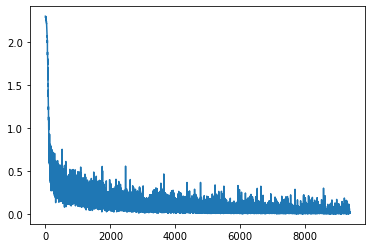

In [6]:
train_losses = []
for epoch in range(10):
    for X, y in train:
        X = X.view(-1, 784)  # разгладим картинку в вектор
        
        optimizer.zero_grad()
        
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        train_losses.append(loss.item())
        # как думаете, зачем нужен .item()?
        # подсказка: лосс хранит информацию о своей истории
        # попробуйте убрать .item() и посмотреть на расход памяти
        
        optimizer.step()
    
    print(accuracy(model, train), accuracy(model, val))
        
plt.plot(train_losses)
plt.show()

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        d = 1024
        d2 = 1024 
        d3 = 1024
        self.encode = nn.Sequential(
            nn.Linear(28*28, d),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Linear(d, d2),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(d2, d3),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(d3, 2),            
        )
        
        self.decode = nn.Sequential(
            # а теперь наоборот - из Х-мерного в картинку
            nn.Linear(2, d3),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(d3, d2),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(d2, d),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(d, 28*28),

            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()
#                    ^ попробуйте также другие меры разности (например, абсолютную ошибку)
optimizer = torch.optim.Adam(model.parameters())

In [15]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0484
epoch 1, loss 0.0418
epoch 2, loss 0.0394
epoch 3, loss 0.0384
epoch 4, loss 0.0375
epoch 5, loss 0.0371
epoch 6, loss 0.0365
epoch 7, loss 0.0362
epoch 8, loss 0.0361
epoch 9, loss 0.0360


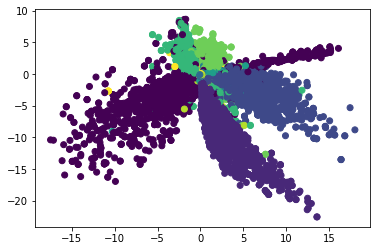

In [16]:
import pandas as pd
import numpy as np
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

idx = numpy.random.randint(0, len(train.dataset), len(train.dataset))
latent = [model.encode(get(k)).data.numpy() for k in idx]
x = np.array(latent).reshape(-1, 2)
y =  np.array([ train.dataset[k][1] for k in idx])
plt.scatter(x[:, 0],x[:, 1], c = y)

In [17]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [18]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

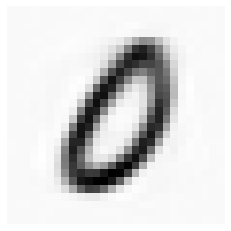

In [19]:
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)